# What drives the price of a car?

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

The primary business goal is to pinpoint essential features influencing used car prices. This insight equips Car Dealers and their Sales Teams to optimize their inventory, thereby boosting sales. 

The task involves meticulous data preprocessing, strategic feature engineering, and the development of a robust predictive model. Ultimately, crafting an effective model capable of reliably estimating used car prices.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [80]:
# Import Libraries

from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [81]:
# Read the data from csv to Dataframe Save to df
vehicles = pd.read_csv('data/vehicles.csv')

In [82]:
# Shape and preview
print('Vehicles DataFrame Shape :',vehicles.shape)
pd.set_option('display.max_columns', None)
vehicles.head()

Vehicles DataFrame Shape : (426880, 18)


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [83]:
# Use Dataframe describe/view some basic statistical details like percentile, mean, std etc. of the dataset
vehicles.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [84]:
# Exploring the data, lets start by describing the dataframe to get a list of provided attributes/features
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [85]:
# Print percentage of Columns that are null in relation to the total number of columns
for column in vehicles.columns:
    if vehicles[column].isnull().sum() > 0:
        print(column, ': {:.2%}'.format(vehicles[column].isnull().sum() /
                                               vehicles[column].shape[0]))

year : 0.28%
manufacturer : 4.13%
model : 1.24%
condition : 40.79%
cylinders : 41.62%
fuel : 0.71%
odometer : 1.03%
title_status : 1.93%
transmission : 0.60%
VIN : 37.73%
drive : 30.59%
size : 71.77%
type : 21.75%
paint_color : 30.50%


In [86]:
#Check the number of Null Columns
vehicles.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

<Axes: >

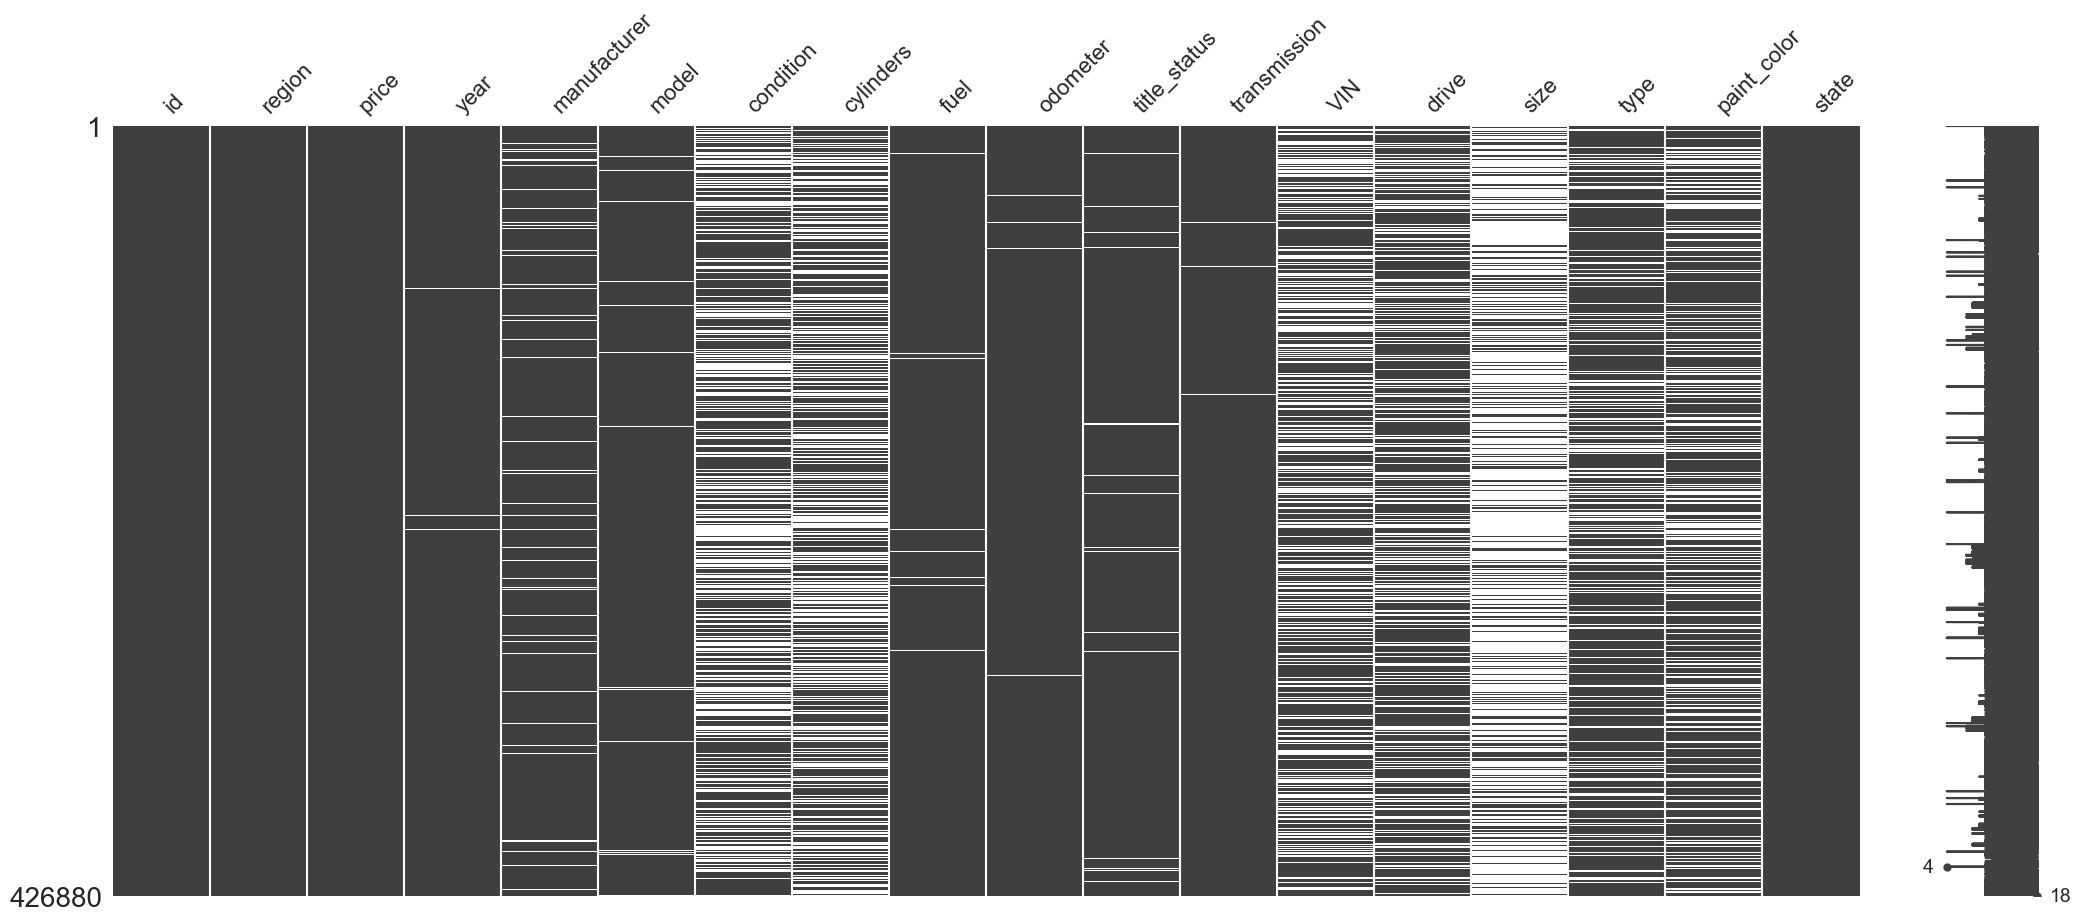

In [87]:
import missingno as msno

# Plot the missing values
msno.matrix(vehicles)

In [88]:
vehicles_cleanprice = vehicles.query("price > 0").dropna()

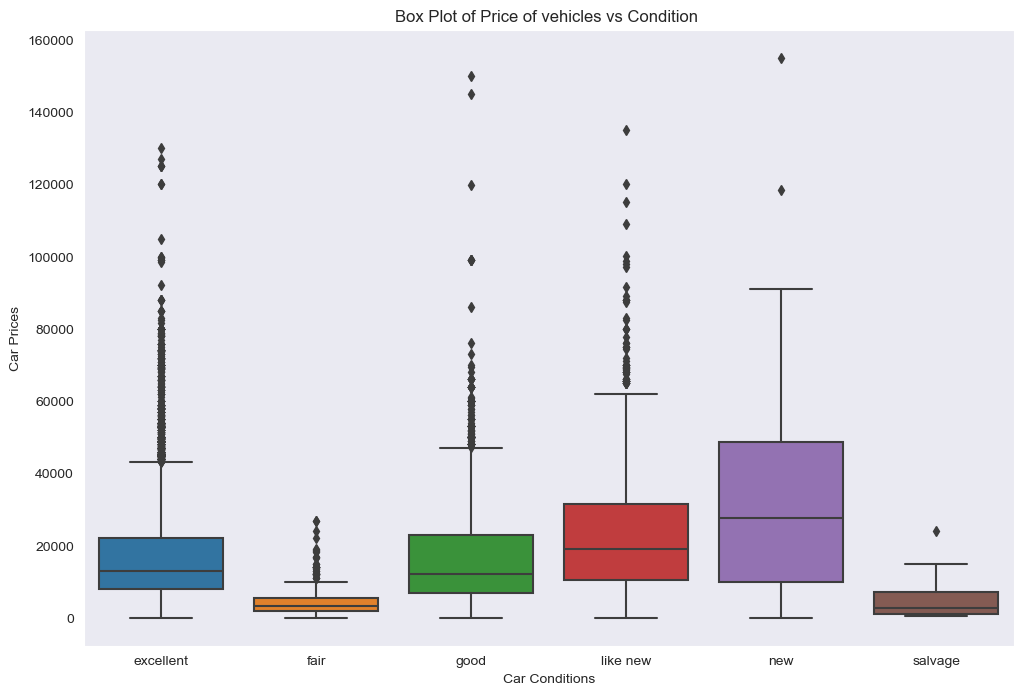

In [89]:
#plt.figure(figsize=(12,8))

fig, ax = plt.subplots(figsize=(12,8))

#create seaborn boxplot
ax = sns.boxplot(x=vehicles_cleanprice["condition"], y=vehicles_cleanprice["price"], ax=ax)

# Adding Title to the Plot
ax.set_title("Box Plot of Price of vehicles vs Condition ")
 
# Setting the X and Y labels
ax.set_xlabel("Car Conditions")
ax.set_ylabel("Car Prices")

plt.show()

In [90]:
# Create Group for Year
bins = [1900, 2000, 2005, 2010, 2015, 2020, 2025]
group = ['<2000', '2000-2005' ,'2005-2010','2010-2015','2015-2020','>2024']
vehicles['YearGroup'] = pd.cut(x=vehicles['year'], bins=bins, labels=group)
vehicles['YearGroup'].value_counts()

YearGroup
2015-2020    147896
2010-2015    136854
2005-2010     72800
2000-2005     36774
<2000         28810
>2024          2529
Name: count, dtype: int64

In [91]:
# Create Group for Odometer
vehicles['odometer'].min()
bins = [0, 15000, 30000, 60000, 90000 ,120000, 150000, 180000, 210000]
group = ['<15K', '30K-60K', '60K-90K','90K-120K','120K-150K','150K-180K','180K-210K','>210K']
vehicles['OdometerGroup'] = pd.cut(x=vehicles['odometer'], bins=bins, labels=group)
vehicles['OdometerGroup'].value_counts()

OdometerGroup
60K-90K      70295
120K-150K    69015
90K-120K     66238
150K-180K    55986
30K-60K      42141
<15K         40603
180K-210K    37293
>210K        20693
Name: count, dtype: int64

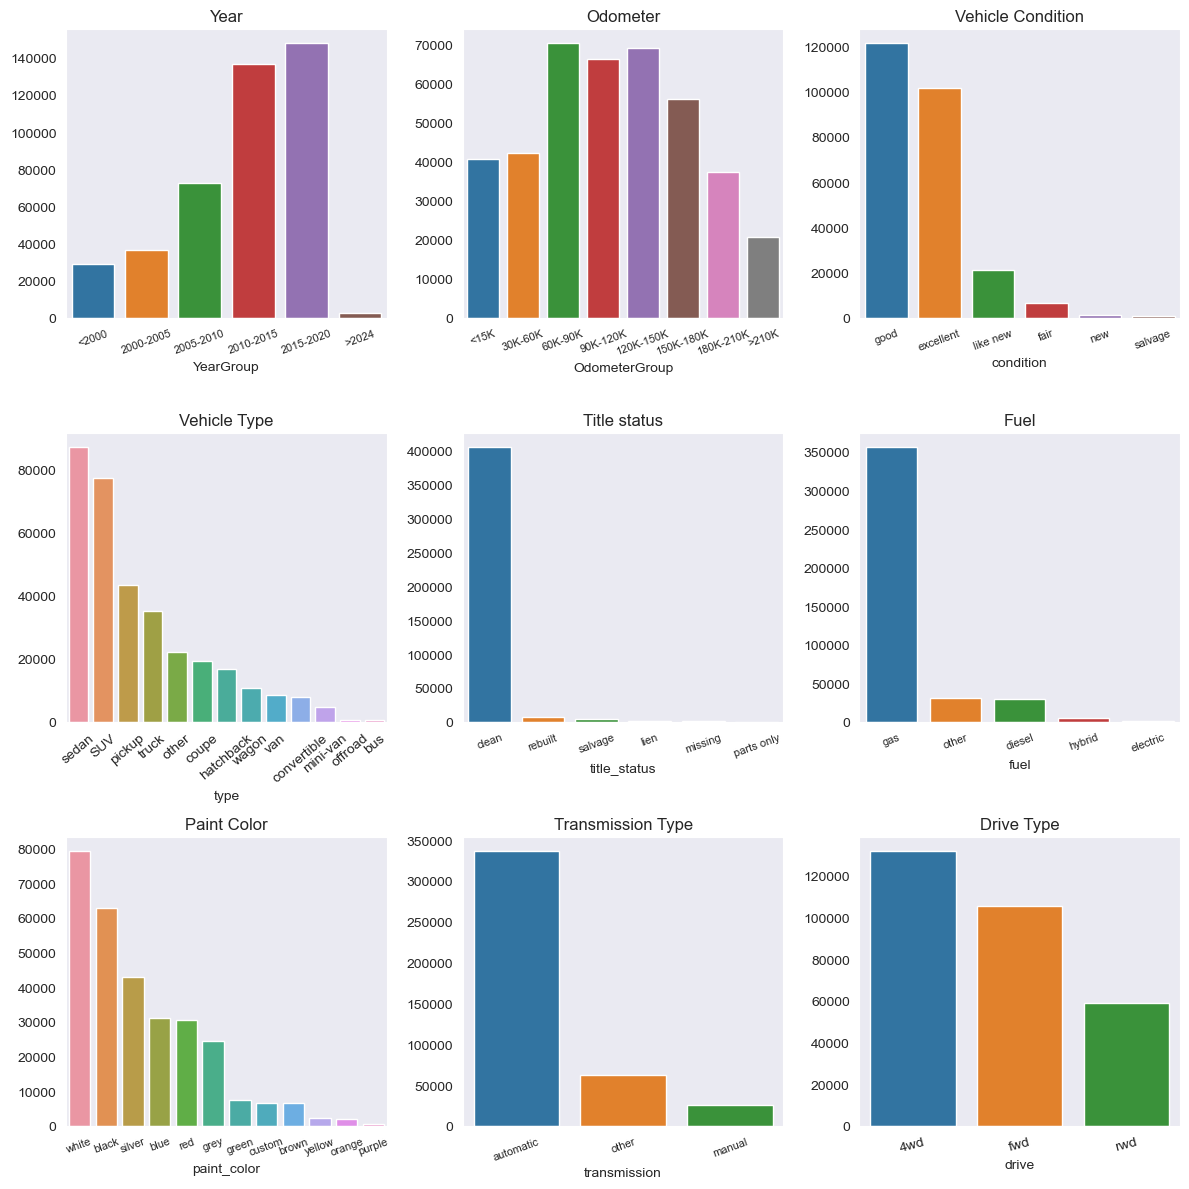

In [92]:
#Set Style to Dark
sns.set_style("dark")

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

df = vehicles

# Plot for 'Year' 
value_counts = df['YearGroup'].value_counts()
sns.barplot(x=value_counts.index, y=value_counts.values,ax=axes[0, 0])
axes[0, 0].set_title('Year')
axes[0, 0].tick_params(axis='x', labelrotation=20,labelsize=8)

# Plot for 'Odometer Reading' 
value_counts = df['OdometerGroup'].value_counts()
sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[0, 1])
axes[0, 1].set_title('Odometer')
axes[0, 1].tick_params(axis='x', labelrotation=20,labelsize=8)

# Plot for 'Vehicle condition' 
df1 = df.loc[(df['condition'] != 'unknown')]
value_counts = df1['condition'].value_counts()
sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[0, 2])
axes[0, 2].set_title('Vehicle Condition')
axes[0, 2].tick_params(axis='x', labelrotation=20,labelsize=8)


# Plot for 'Vehicle Type' 
df1 = df.loc[(df['type'] != 'unknown')]
value_counts = df1['type'].value_counts()
sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[1, 0])
axes[1, 0].set_title('Vehicle Type')
axes[1, 0].tick_params(axis='x', labelrotation=40)
    
# Plot for 'Title Status' 
df1 = df.loc[(df['title_status'] != 'unknown')]
value_counts = df1['title_status'].value_counts()
highest_values = value_counts.nlargest(8)
sns.barplot(x=highest_values.index, y=highest_values.values, ax=axes[1, 1])
axes[1, 1].set_title('Title status')
axes[1, 1].tick_params(axis='x', labelrotation=20,labelsize=8)


# Plot for 'fuel' 
df1 = df.loc[(df['fuel'] != 'unknown')]
value_counts = df1['fuel'].value_counts()
highest_values = value_counts.nlargest(8)
sns.barplot(x=highest_values.index, y=highest_values.values, ax=axes[1, 2])
axes[1, 2].set_title('Fuel')
axes[1, 2].tick_params(axis='x', labelrotation=20,labelsize=8)


# Plot for 'Paint Color' 
df1 = df.loc[(df['paint_color'] != 'unknown')]
value_counts = df1['paint_color'].value_counts()
sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[2, 0])
axes[2, 0].set_title('Paint Color')
axes[2, 0].tick_params(axis='x', labelrotation=20,labelsize=8)
#for index, value in enumerate(value_counts.values):
#    axes[1, 1].text(index, value + 0.5, str(round(value,1)), ha='center', va='bottom')
    

# Plot for 'transmission' 
df1 = df.loc[(df['transmission'] != 'unknown')]
value_counts = df1['transmission'].value_counts()
highest_values = value_counts.nlargest(8)
sns.barplot(x=highest_values.index, y=highest_values.values, ax=axes[2, 1])
axes[2, 1].set_title('Transmission Type')
axes[2, 1].tick_params(axis='x', labelrotation=20,labelsize=8)


# Plot for 'Drive' 
df1 = df.loc[(df['drive'] != 'unknown')]
value_counts = df1['drive'].value_counts()
highest_values = value_counts.nlargest(8)
sns.barplot(x=highest_values.index, y=highest_values.values, ax=axes[2, 2])
axes[2, 2].set_title('Drive Type')
axes[2, 2].tick_params(axis='x', labelrotation=20,labelsize=8)
       


# Adjust layout
plt.tight_layout()
plt.xticks(rotation=15)
plt.xticks(fontsize=10)


# Show the plots
plt.show()

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [93]:
# We start the data preparation by taking a copy of the loaded dataset and dropping null rows
clean_vehicles = vehicles.copy().dropna()
clean_vehicles.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state,YearGroup,OdometerGroup
126,7305672709,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,68472.0,clean,automatic,1GCWGAFP8J1309579,rwd,full-size,van,white,al,2015-2020,90K-120K
127,7305672266,auburn,0,2019.0,chevrolet,express cargo van,like new,6 cylinders,gas,69125.0,clean,automatic,1GCWGAFP4K1214373,rwd,full-size,van,white,al,2015-2020,90K-120K
128,7305672252,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,66555.0,clean,automatic,1GCWGAFPXJ1337903,rwd,full-size,van,white,al,2015-2020,90K-120K
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al,2000-2005,180K-210K
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al,<2000,120K-150K


In [94]:
#Let's print the number of records
clean_vehicles.shape

(33289, 20)

In [95]:
# Reviewing the records, we can state that id and VIN are not useful for predicting the car price
# Attributes region and state are also duplicates. We can remove one for now. 
# Removing region as the unique count shows some region with 1 car
# Drop the following columns
clean_vehicles.drop('id', axis=1, inplace=True)
clean_vehicles.drop('VIN', axis=1, inplace=True)
clean_vehicles.drop('region', axis=1, inplace=True)
clean_vehicles

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,YearGroup,OdometerGroup
126,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,68472.0,clean,automatic,rwd,full-size,van,white,al,2015-2020,90K-120K
127,0,2019.0,chevrolet,express cargo van,like new,6 cylinders,gas,69125.0,clean,automatic,rwd,full-size,van,white,al,2015-2020,90K-120K
128,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,66555.0,clean,automatic,rwd,full-size,van,white,al,2015-2020,90K-120K
215,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,fwd,compact,sedan,blue,al,2000-2005,180K-210K
219,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,rwd,mid-size,sedan,white,al,<2000,120K-150K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426788,12995,2016.0,chevrolet,cruze lt,like new,4 cylinders,gas,61127.0,clean,automatic,fwd,compact,sedan,silver,wy,2015-2020,90K-120K
426792,32999,2014.0,ford,"f350, xlt",excellent,8 cylinders,diesel,154642.0,clean,automatic,4wd,full-size,pickup,brown,wy,2010-2015,180K-210K
426793,15999,2018.0,chevrolet,"cruze, lt",excellent,4 cylinders,gas,36465.0,clean,automatic,fwd,mid-size,sedan,black,wy,2015-2020,60K-90K
426833,6800,1997.0,jaguar,xk8 convertible,good,8 cylinders,gas,69550.0,clean,automatic,rwd,compact,convertible,white,wy,<2000,90K-120K


In [96]:
#Check on which columns are nulls
clean_vehicles.isnull().sum()

price            0
year             0
manufacturer     0
model            0
condition        0
cylinders        0
fuel             0
odometer         0
title_status     0
transmission     0
drive            0
size             0
type             0
paint_color      0
state            0
YearGroup        0
OdometerGroup    0
dtype: int64

In [97]:
# Get the count of Zeros in column 'price' 
count = (clean_vehicles['price'] == 0).sum()
print('Count of zeros in Column  price : ', count)

Count of zeros in Column  price :  2321


In [98]:
# Get the count of Zeros in column 'odometer' 
count = (clean_vehicles['odometer'] == 0).sum()
print('Count of zeros in Column  odometer : ', count)

Count of zeros in Column  odometer :  0


In [78]:
# With 33289  records, we have 81 records with zero odometers and 2,321 with zero dollars for price.
# We will remove these records 

In [99]:
# Removing records with zero for Odometer and Prices
# Remove rows with all 0s in a Dataframe
clean_vehicles.drop(clean_vehicles[clean_vehicles['price'] == 0].index, inplace = True)
clean_vehicles.drop(clean_vehicles[clean_vehicles['odometer'] == 0].index, inplace = True)
clean_vehicles

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,YearGroup,OdometerGroup
215,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,fwd,compact,sedan,blue,al,2000-2005,180K-210K
219,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,rwd,mid-size,sedan,white,al,<2000,120K-150K
268,9000,2008.0,mazda,miata mx-5,excellent,4 cylinders,gas,56700.0,clean,automatic,rwd,compact,convertible,white,al,2005-2010,60K-90K
337,8950,2011.0,ford,f-150,excellent,6 cylinders,gas,164000.0,clean,automatic,fwd,full-size,truck,white,al,2010-2015,180K-210K
338,4000,1972.0,mercedes-benz,benz,fair,6 cylinders,gas,88100.0,clean,automatic,rwd,full-size,coupe,silver,al,<2000,90K-120K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426785,23495,2015.0,ford,f150 xlt 4x4,like new,8 cylinders,gas,146795.0,clean,automatic,4wd,full-size,truck,black,wy,2010-2015,150K-180K
426788,12995,2016.0,chevrolet,cruze lt,like new,4 cylinders,gas,61127.0,clean,automatic,fwd,compact,sedan,silver,wy,2015-2020,90K-120K
426792,32999,2014.0,ford,"f350, xlt",excellent,8 cylinders,diesel,154642.0,clean,automatic,4wd,full-size,pickup,brown,wy,2010-2015,180K-210K
426793,15999,2018.0,chevrolet,"cruze, lt",excellent,4 cylinders,gas,36465.0,clean,automatic,fwd,mid-size,sedan,black,wy,2015-2020,60K-90K


In [100]:
# Quick check to ensure all rows do not include any zero values
temp = clean_vehicles.eq(0).any()
temp

price            False
year             False
manufacturer     False
model            False
condition        False
cylinders        False
fuel             False
odometer         False
title_status     False
transmission     False
drive            False
size             False
type             False
paint_color      False
state            False
YearGroup        False
OdometerGroup    False
dtype: bool

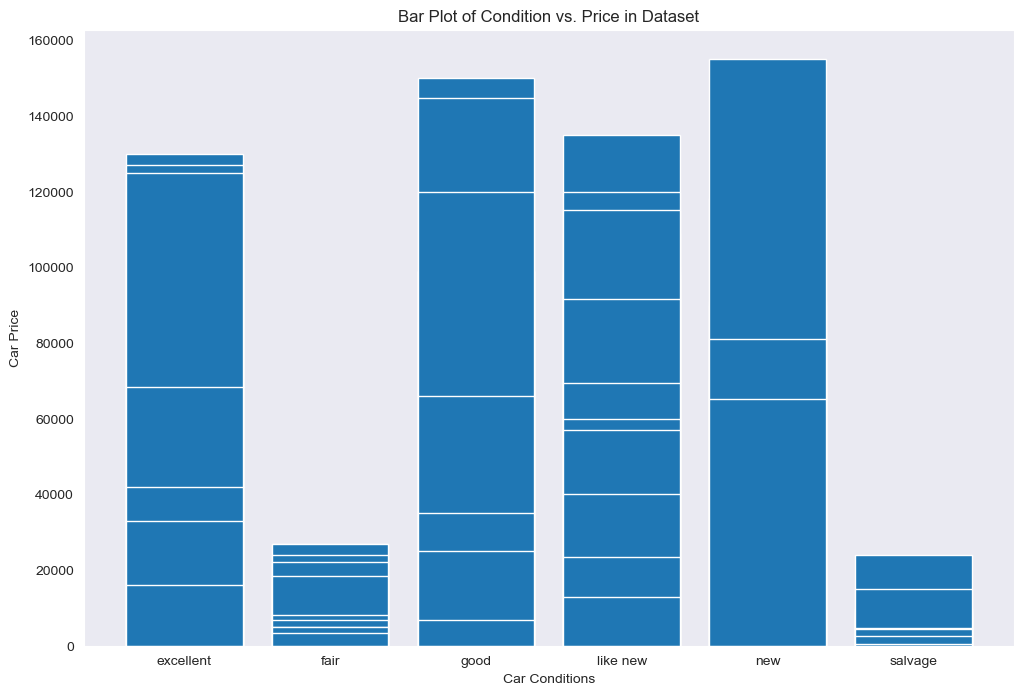

In [101]:
# Lets look at a scatter plot of the odometer and price to see the distribution of data
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(clean_vehicles["condition"],clean_vehicles["price"])
# set a title and labels
ax.set_title('Bar Plot of Condition vs. Price in Dataset')
ax.set_xlabel('Car Conditions')
ax.set_ylabel('Car Price')
plt.show()

#plt.bar(data_copy["condition"],data_copy["price"])
#plt.show()

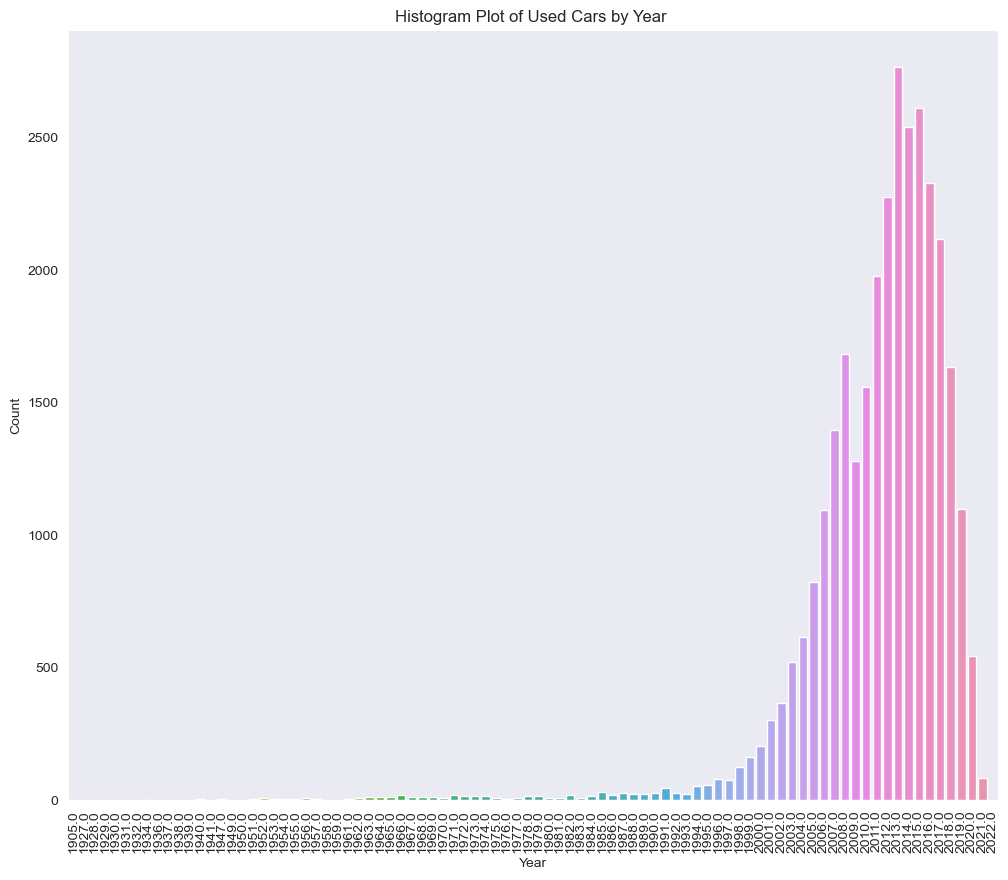

In [102]:
# Plot the number of used car counts by year

fig, ax = plt.subplots(figsize=(12,10))

#create seaborn boxplot
ax = sns.countplot(x='year', data=clean_vehicles , ax=ax)

# Adding Title to the Plot
ax.set_title("Histogram Plot of Used Cars by Year ")

#rotate x-axis and y-axis tick labels
plt.xticks(rotation=90)
    
   
# Setting the X and Y labels
ax.set_xlabel("Year")
ax.set_ylabel("Count")

plt.show()

In [ ]:
# From the chart above, you can see that the records from 1905 to 1990 were not extensive. You restrict the records in
# the model from 1991

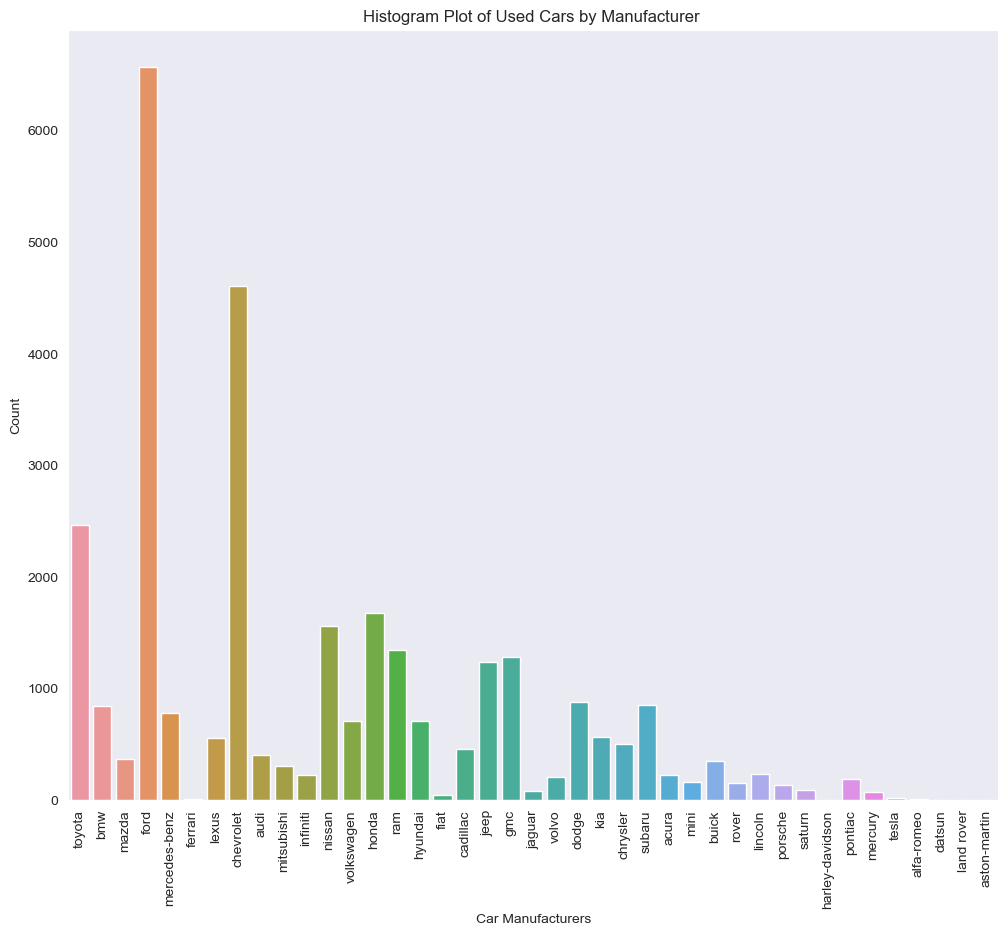

In [103]:
# Plot the number of used car counts by manufacturer

fig, ax = plt.subplots(figsize=(12,10))

#create seaborn boxplot
ax = sns.countplot(x='manufacturer', data=clean_vehicles , ax=ax)

# Adding Title to the Plot
ax.set_title("Histogram Plot of Used Cars by Manufacturer ")

#rotate x-axis and y-axis tick labels
plt.xticks(rotation=90)
    
   
# Setting the X and Y labels
ax.set_xlabel("Car Manufacturers")
ax.set_ylabel("Count")

plt.show()

In [ ]:
# From the chart above, you can see that Ford, Chevrolet and Toyota are the top 3 manufacturers

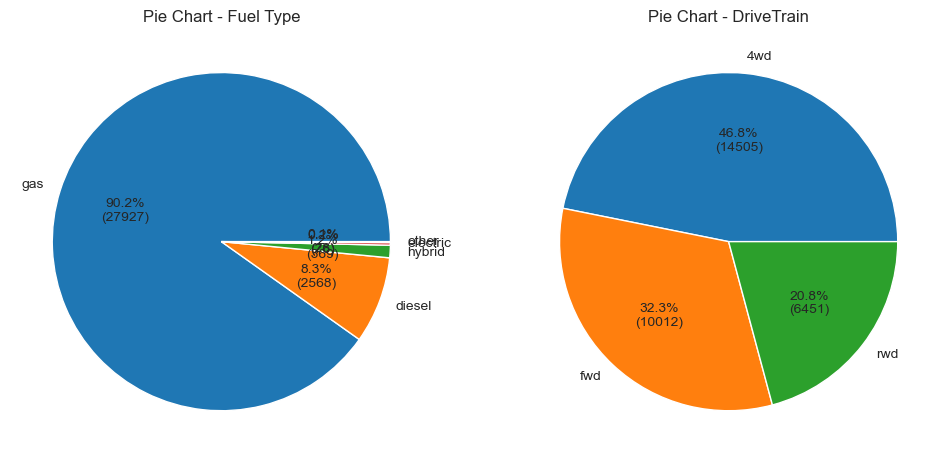

In [104]:
# Plot some pie charts to visualize the number of used cars based on car features
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

#plt.pie(df['LoanStatus'].value_counts().values, labels=df['LoanStatus'].value_counts().index, autopct=fmt)

# create a figure with two subplots
#fig, ax = plt.subplots(figsize=(12,8))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,7))

# plot each pie chart in a separate subplot

ax1.set_title('Pie Chart - Fuel Type')
s = clean_vehicles['fuel'].value_counts()
ax1.pie(s,labels = s.index,  autopct=autopct_format(s))

ax2.set_title('Pie Chart - DriveTrain')
s = clean_vehicles['drive'].value_counts()
ax2.pie(s,labels = s.index, autopct=autopct_format(s))

plt.show()

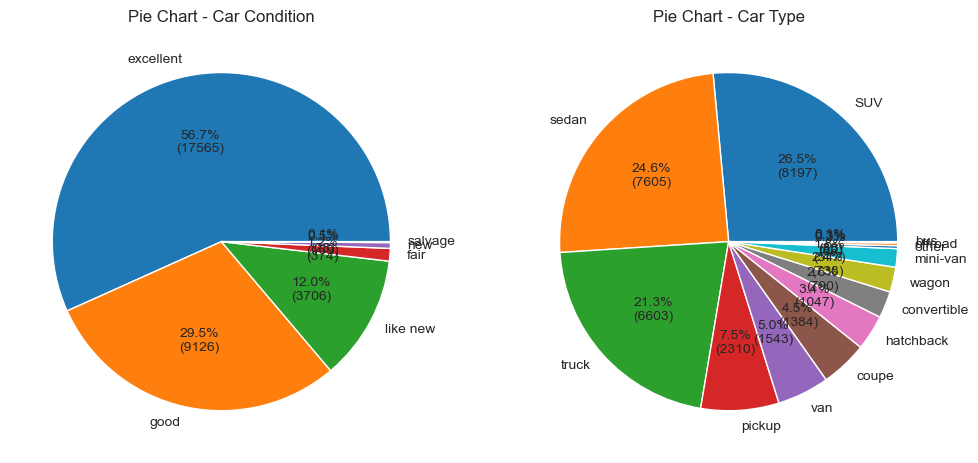

In [105]:
# create a figure with two subplots
#fig, ax = plt.subplots(figsize=(12,8))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,7))

# plot each pie chart in a separate subplot

ax1.set_title('Pie Chart - Car Condition')
s = clean_vehicles['condition'].value_counts()
ax1.pie(s,labels = s.index,  autopct=autopct_format(s))

ax2.set_title('Pie Chart - Car Type')
s = clean_vehicles['type'].value_counts()
ax2.pie(s,labels = s.index, autopct=autopct_format(s))


plt.show()

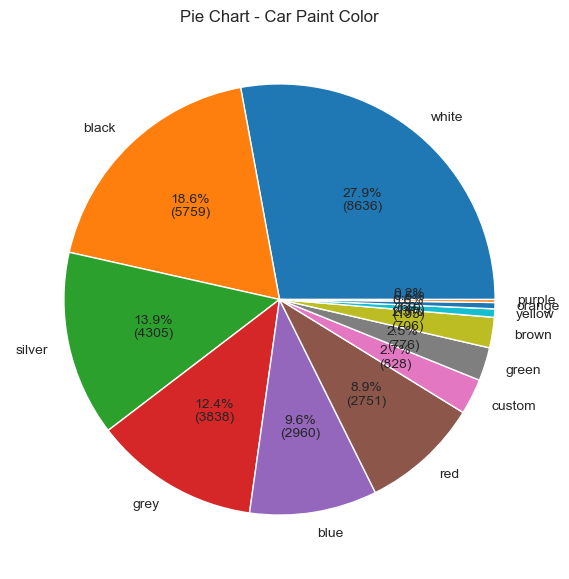

In [106]:
# create a figure with subplots
#fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(12,7))

# plot each pie chart in a separate subplot

ax.set_title('Pie Chart - Car Paint Color')
s = clean_vehicles['paint_color'].value_counts()
ax.pie(s,labels = s.index, autopct=autopct_format(s))


plt.show()

In [108]:
clean_vehicles['state'].value_counts()

state
fl    3271
ca    3146
ny    1690
tx    1220
mi    1161
wi    1067
nc    1034
ia     998
oh     990
pa     976
va     928
or     904
tn     807
nj     766
mn     748
co     700
vt     675
ma     637
il     608
id     576
az     572
ks     561
in     544
ky     529
ok     469
sc     421
ak     397
al     385
mo     356
mt     331
wa     284
ct     279
ga     243
nm     227
ri     225
nv     215
hi     206
me     193
nh     182
dc     174
md     156
ut     143
sd     138
ar     131
ne     128
nd     125
la     121
de     106
wv      85
wy      84
ms      56
Name: count, dtype: int64

In [109]:
clean_vehicles['paint_color'].value_counts()

paint_color
white     8636
black     5759
silver    4305
grey      3838
blue      2960
red       2751
custom     828
green      776
brown      706
yellow     195
orange     145
purple      69
Name: count, dtype: int64

In [110]:
clean_vehicles['manufacturer'].value_counts()

manufacturer
ford               6571
chevrolet          4608
toyota             2468
honda              1679
nissan             1566
ram                1345
gmc                1284
jeep               1241
dodge               879
subaru              852
bmw                 844
mercedes-benz       786
hyundai             711
volkswagen          711
kia                 571
lexus               558
chrysler            502
cadillac            459
audi                406
mazda               373
buick               351
mitsubishi          307
lincoln             234
acura               230
infiniti            223
volvo               213
pontiac             188
mini                166
rover               156
porsche             135
saturn               91
jaguar               82
mercury              73
fiat                 47
tesla                19
alfa-romeo           15
ferrari               9
harley-davidson       7
datsun                3
aston-martin          3
land rover            2
Nam

In [111]:
clean_vehicles['model'].value_counts()

model
f-150                     773
silverado 1500            732
1500                      389
super duty f-550 drw      247
2500                      242
                         ... 
montana sv6                 1
rondo ex                    1
sentra special edition      1
2500 st                     1
cruze, 2lt                  1
Name: count, Length: 4791, dtype: int64

In [112]:
clean_vehicles['cylinders'].value_counts()

cylinders
4 cylinders     10367
6 cylinders     10274
8 cylinders      9382
10 cylinders      533
5 cylinders       251
other              85
3 cylinders        66
12 cylinders       10
Name: count, dtype: int64

In [113]:
clean_vehicles['type'].value_counts()

type
SUV            8197
sedan          7605
truck          6603
pickup         2310
van            1543
coupe          1384
hatchback      1047
convertible     790
wagon           738
mini-van        547
other            86
offroad          80
bus              38
Name: count, dtype: int64

In [114]:
clean_vehicles['transmission'].value_counts()

transmission
automatic    28743
manual        1539
other          686
Name: count, dtype: int64

In [115]:
clean_vehicles['title_status'].value_counts()

title_status
clean         29814
rebuilt         779
salvage         231
lien            130
missing          13
parts only        1
Name: count, dtype: int64

Based on the data for these features, we can drop these features due to the following:

state has a lot of options and this feature should not have a big impact on price
paint_color has a number of unique values with white being the most dominant. Should not have a big impact on price
manufacturer is varied with ford with the most number of vehicles
model has 4943 and should not have a big impact on price
cylinders should not have a big impact on price
type should not have a big impact on price
transmission is mainly automatic so we can drop
title_status can be dropped, we have condition field

In [116]:
clean_vehicles.drop(['state', 'paint_color', 'manufacturer', 'model', 'cylinders', 'type', 'transmission', 'title_status'], axis=1,  inplace=True)
clean_vehicles.head(5)

,price,year,condition,fuel,odometer,drive,size,YearGroup,OdometerGroup
215,4000,2002.0,excellent,gas,155000.0,fwd,compact,2000-2005,180K-210K
219,2500,1995.0,fair,gas,110661.0,rwd,mid-size,<2000,120K-150K
268,9000,2008.0,excellent,gas,56700.0,rwd,compact,2005-2010,60K-90K
337,8950,2011.0,excellent,gas,164000.0,fwd,full-size,2010-2015,180K-210K
338,4000,1972.0,fair,gas,88100.0,rwd,full-size,<2000,90K-120K


In [117]:
clean_vehicles.drop(['YearGroup', 'OdometerGroup'], axis=1,  inplace=True)
clean_vehicles.head(5)

,price,year,condition,fuel,odometer,drive,size
215,4000,2002.0,excellent,gas,155000.0,fwd,compact
219,2500,1995.0,fair,gas,110661.0,rwd,mid-size
268,9000,2008.0,excellent,gas,56700.0,rwd,compact
337,8950,2011.0,excellent,gas,164000.0,fwd,full-size
338,4000,1972.0,fair,gas,88100.0,rwd,full-size


In [119]:
#create categorical variables and drop some variables
model_data_df=pd.get_dummies(clean_vehicles, columns=["condition","fuel","size", "drive"])
model_data_df.head()

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,size_compact,size_full-size,size_mid-size,size_sub-compact,drive_4wd,drive_fwd,drive_rwd
215,4000,2002.0,155000.0,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False
219,2500,1995.0,110661.0,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True
268,9000,2008.0,56700.0,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True
337,8950,2011.0,164000.0,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False
338,4000,1972.0,88100.0,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True


In [121]:
#Lets look at the Correlation after some data manipulation
model_data_df.corr()

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,size_compact,size_full-size,size_mid-size,size_sub-compact,drive_4wd,drive_fwd,drive_rwd
price,1.000000,0.302664,-0.400094,-0.038658,-0.105449,-0.045408,0.143565,0.075657,-0.026569,0.432748,0.019425,-0.389322,-0.038393,-0.009248,-0.203516,0.316339,-0.182071,-0.062341,0.300786,-0.383769,0.072423
year,0.302664,1.000000,-0.270059,0.070513,-0.156674,-0.138227,0.129867,0.043265,-0.004795,0.032358,0.030183,-0.040628,0.020666,-0.018934,0.011252,0.008943,-0.013646,-0.014593,0.145710,0.030829,-0.214550
odometer,-0.400094,-0.270059,1.000000,-0.015203,0.091163,0.161392,-0.218619,-0.066738,-0.004288,0.054946,-0.052867,-0.040384,-0.004643,-0.000502,-0.098517,0.101041,-0.037074,-0.009140,0.037608,0.022634,-0.072281
condition_excellent,-0.038658,0.070513,-0.015203,1.000000,-0.126573,-0.739975,-0.422082,-0.084800,-0.034438,-0.034639,-0.014630,0.029315,0.013036,0.004594,0.067704,-0.092659,0.040150,0.042766,0.049604,0.030126,-0.095650
condition_fair,-0.105449,-0.156674,0.091163,-0.126573,1.000000,-0.071468,-0.040765,-0.008190,-0.003326,-0.022527,-0.005484,0.021583,-0.003968,0.016346,0.011175,-0.025087,0.020702,-0.003981,-0.028542,0.017751,0.014626
condition_good,-0.045408,-0.138227,0.161392,-0.739975,-0.071468,1.000000,-0.238324,-0.047882,-0.019445,0.050401,-0.014883,-0.031857,-0.032469,-0.005306,-0.078695,0.113103,-0.057971,-0.031762,-0.030162,-0.058217,0.104115
condition_like new,0.143565,0.129867,-0.218619,-0.422082,-0.040765,-0.238324,1.000000,-0.027312,-0.011092,-0.009134,0.046055,-0.006044,0.020026,-0.004471,0.000532,-0.005899,0.012860,-0.022619,-0.025089,0.027193,-0.000491
condition_new,0.075657,0.043265,-0.066738,-0.084800,-0.008190,-0.047882,-0.027312,1.000000,-0.002228,-0.003201,-0.003674,-0.006488,0.028222,-0.002228,0.007816,-0.007005,-0.001801,0.012885,0.007767,0.006899,-0.017490
condition_salvage,-0.026569,-0.004795,-0.004288,-0.034438,-0.003326,-0.019445,-0.011092,-0.002228,1.000000,-0.005150,-0.001492,0.002706,0.006598,-0.000905,0.012088,-0.016096,0.007776,0.003948,-0.004553,0.011365,-0.007494
fuel_diesel,0.432748,0.032358,0.054946,-0.034639,-0.022527,0.050401,-0.009134,-0.003201,-0.005150,1.000000,-0.014915,-0.911260,-0.033022,-0.009046,-0.105423,0.233754,-0.168933,-0.040042,0.171346,-0.186818,0.004629


In [122]:
model_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30968 entries, 215 to 426833
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                30968 non-null  int64  
 1   year                 30968 non-null  float64
 2   odometer             30968 non-null  float64
 3   condition_excellent  30968 non-null  bool   
 4   condition_fair       30968 non-null  bool   
 5   condition_good       30968 non-null  bool   
 6   condition_like new   30968 non-null  bool   
 7   condition_new        30968 non-null  bool   
 8   condition_salvage    30968 non-null  bool   
 9   fuel_diesel          30968 non-null  bool   
 10  fuel_electric        30968 non-null  bool   
 11  fuel_gas             30968 non-null  bool   
 12  fuel_hybrid          30968 non-null  bool   
 13  fuel_other           30968 non-null  bool   
 14  size_compact         30968 non-null  bool   
 15  size_full-size       30968 non-null  b

In [123]:
# Check if there is still bad data in the data set, i.e., unrealistic values in the attributes
temp = model_data_df.eq(1).any()
temp

price                   True
year                   False
odometer                True
condition_excellent     True
condition_fair          True
condition_good          True
condition_like new      True
condition_new           True
condition_salvage       True
fuel_diesel             True
fuel_electric           True
fuel_gas                True
fuel_hybrid             True
fuel_other              True
size_compact            True
size_full-size          True
size_mid-size           True
size_sub-compact        True
drive_4wd               True
drive_fwd               True
drive_rwd               True
dtype: bool

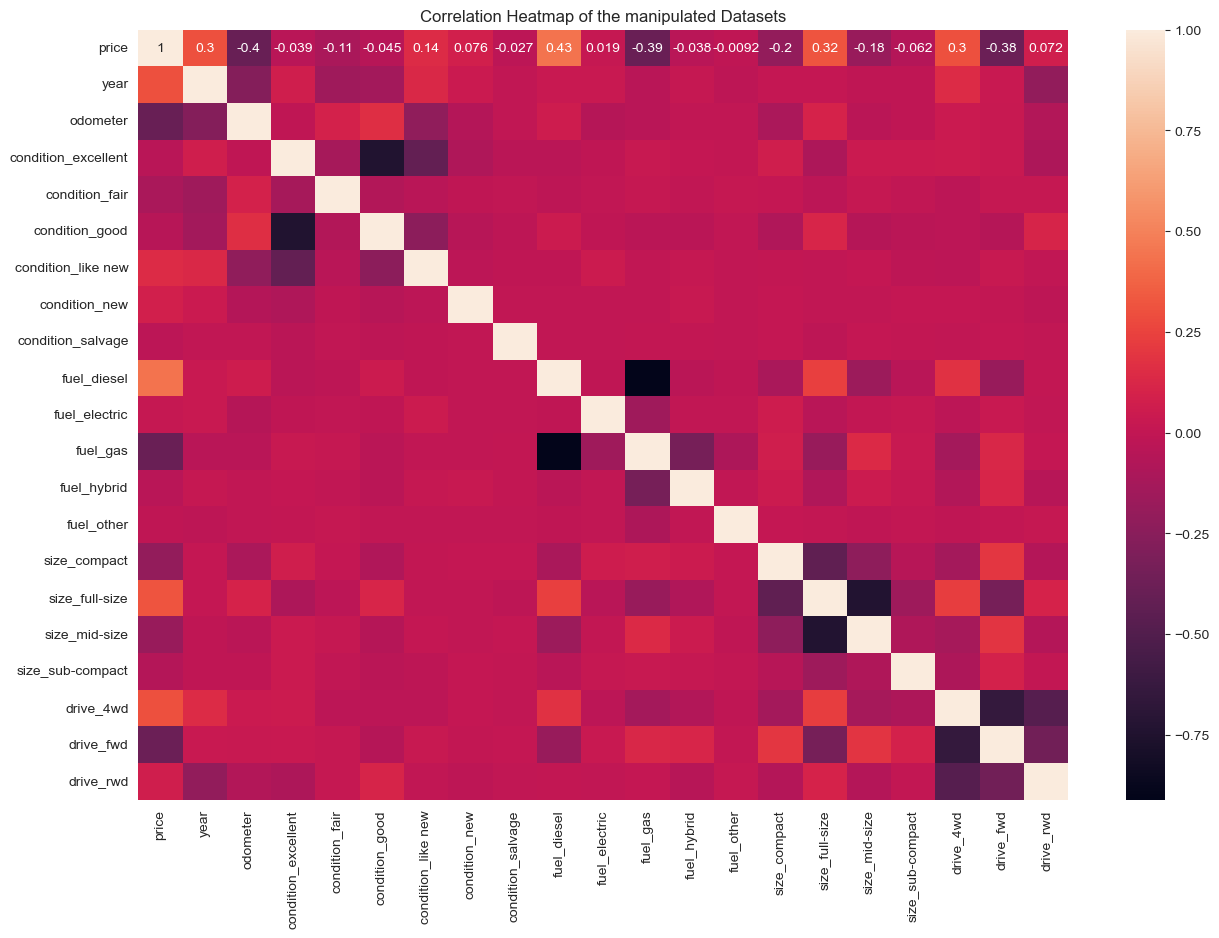

In [124]:
# Now lets look at the heatmap for the final data set

fig, ax = plt.subplots(figsize=(15,10))
plt.rcParams["figure.autolayout"] = True

#create seaborn heatmap
ax = sns.heatmap(model_data_df.corr(), annot = True)

# Adding Title to the Plot
ax.set_title("Correlation Heatmap of the manipulated Datasets")
manager = plt.get_current_fig_manager()
manager.full_screen_toggle()
plt.show()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [125]:
## Lets split the data to training and test sets, 70/30 split ratio so that we can assess how well the model 
## can predict car prices
X = model_data_df.drop(['price'], axis = 1)
y = model_data_df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [126]:
#First, we create a new model object. Using fit intercept = false sets the y-intercept to 0.
model=LinearRegression(fit_intercept=False)

In [127]:
# With model created, let's fit the model using the manipulated datasets
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [128]:
# Fitted model can now be used to examine the estimated coefficients and also predict ths value of the dependent
# for a given set of independent variables which in this model is the manipulated dataset
print("Coefficient of the model: ",model.coef_)
print("Intercept of the model: ", model.intercept_)

Coefficient of the model:  [ 3.16548092e+02 -1.02672531e-01 -1.06772106e+05 -1.09591974e+05
 -1.06731249e+05 -1.04949708e+05 -9.71715868e+04 -1.15387406e+05
 -1.15243667e+05 -1.29476567e+05 -1.32144756e+05 -1.30811150e+05
 -1.32927890e+05 -1.63917622e+05 -1.56136999e+05 -1.60112671e+05
 -1.60436738e+05 -2.10739105e+05 -2.18126775e+05 -2.11738150e+05]
Intercept of the model:  0.0


In [129]:
# get the cofficients
[(col, coef) for col, coef in zip (X_train.columns, model.coef_)]

[('year', 316.5480918378367),
 ('odometer', -0.10267253147275124),
 ('condition_excellent', -106772.10630658196),
 ('condition_fair', -109591.97359933106),
 ('condition_good', -106731.24932947497),
 ('condition_like new', -104949.70807392709),
 ('condition_new', -97171.58675367742),
 ('condition_salvage', -115387.40583029417),
 ('fuel_diesel', -115243.66723109077),
 ('fuel_electric', -129476.56724767813),
 ('fuel_gas', -132144.75550444936),
 ('fuel_hybrid', -130811.14964507516),
 ('fuel_other', -132927.89026500355),
 ('size_compact', -163917.62193881613),
 ('size_full-size', -156136.9990186332),
 ('size_mid-size', -160112.67130118638),
 ('size_sub-compact', -160436.7376346642),
 ('drive_4wd', -210739.1045733136),
 ('drive_fwd', -218126.77500643313),
 ('drive_rwd', -211738.1503135432)]

In [130]:
#Let compute the predictions for the entire set of inputs
train_predictions=model.predict(X_train)
train_predictions

array([24677.36442255, 24859.64818803, 21421.8291075 , ...,
       18802.02362538,  4305.91447277, 19248.36288844])

In [131]:
#Compute Accuracy and RMSE to training model
score = model.score(X_train, y_train)
print("Accuracy: ", round(score*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y_train,train_predictions)), 2))

Accuracy:  52.91
RMSE:      9112.81


In [132]:
# Compute Accuracy and RMSE to training model
score = model.score(X_train, y_train)
print("Accuracy: ",  round(score*100, 2))
print("RMSE:     ",np.sqrt(mean_squared_error(y_train,train_predictions)))

Accuracy:  52.91
RMSE:      9112.812703910666


## Linear Regression:

in this example, we first load the preprocessed data and select the relevant features and the target variable. We then create an instance of the LinearRegression class and fit the model on the data using the fit() method. Next, we get the coefficients of the model using the coef_ attribute and normalize them to get the relative importance of each feature. Finally, we print the feature importance. The output will show the importance of each feature relative to the others.

In [134]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd


# Create the linear regression model
lr_model = LinearRegression()

# Fit the model on the training data
lr_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = lr_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: ", mse)
print("R-squared value: ", r2)


Mean Squared Error:  80724953.07204664
R-squared value:  0.5469671397535982


### Feature importance

In [136]:
# Create the linear regression model
lr_model = LinearRegression()

# Fit the model on the data
lr_model.fit(X, y)

# Get the feature importance
coef = lr_model.coef_
coef_norm = abs(coef) / abs(coef).sum()

columns_ = list(model_data_df.columns)
columns_.remove('price')
# Print the feature importance
for i, feature in enumerate(columns_):
    print(feature, coef_norm[i])

year 0.005041814855442425
odometer 1.5612461654474806e-06
condition_excellent 0.0014551757133878338
condition_fair 0.04209443212138062
condition_good 0.0005609902341104338
condition_like new 0.031854905973928135
condition_new 0.13430433094952474
condition_salvage 0.12608097074957064
fuel_diesel 0.19444759166671563
fuel_electric 0.0006963442607411883
fuel_gas 0.0687505327663354
fuel_hybrid 0.04848910951624094
fuel_other 0.0779042936448803
size_compact 0.057061897101933844
size_full-size 0.062105856106566895
size_mid-size 0.0011638389861839719
size_sub-compact 0.006207797990817021
drive_4wd 0.0428818181513116
drive_fwd 0.07088927805803724
drive_rwd 0.028007459906725707


## Polynomial regression:

In this example, we first load the preprocessed data and select the relevant features and the target variable. we create polynomial features using the PolynomialFeatures class and fit the model on the training set using the fit_transform() method. We transform the test set using the transform() method. Then, we fit a linear regression model on the polynomial features using the LinearRegression class and the fit() method. Finally, we predict on the test set using the predict() method and evaluate the model using the R^2 score, which measures how well the model fits the data. The output will show the R^2 score of the model.

In [137]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit the linear regression model on the polynomial features
lr_model = LinearRegression()
lr_model.fit(X_train_poly, y_train)

# Predict on the test set and evaluate the model
y_pred = lr_model.predict(X_test_poly)
r2 = r2_score(y_test, y_pred)
print('R^2 score:', r2)


R^2 score: 0.639733638095265


## Multiple Models

In this example, we first load the preprocessed data and select the relevant features and the target variable. We then split the data into training and testing sets using the train_test_split() function. Next, we fit five regression models on the training set and evaluate them on the test set using the R^2 score. The models we use are:

1. Linear Regression
2. Ridge Regression
3. Lasso Regression
4. Decision Tree Regression
5. Random Forest Regression

For each model, we print the R^2 score and the feature importance. For linear models, we use the coef_ attribute to get the coefficients of the features

In [138]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score


# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Linear Regression R^2 score:', r2)
print('Linear Regression feature importance:')
print(pd.Series(lr_model.coef_, index=columns_).sort_values(ascending=False))

# Ridge Regression
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Ridge Regression R^2 score:', r2)
print('Ridge Regression feature importance:')
print(pd.Series(ridge_model.coef_, index=columns_).sort_values(ascending=False))

# Lasso Regression
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Lasso Regression R^2 score:', r2)
print('Lasso Regression feature importance:')
print(pd.Series(lasso_model.coef_, index=columns_).sort_values(ascending=False))

# Decision Tree Regression
dt_model = DecisionTreeRegressor(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Decision Tree Regression R^2 score:', r2)
print('Decision Tree Regression feature importance:')
print(pd.Series(dt_model.feature_importances_, index=columns_).sort_values(ascending=False))

# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Random Forest Regression R^2 score:', r2)
print('Random Forest Regression feature importance:')
print(pd.Series(rf_model.feature_importances_, index=columns_).sort_values(ascending=False))


Linear Regression R^2 score: 0.5469671397535982
Linear Regression feature importance:
fuel_diesel            12877.138748
condition_new           9595.751562
size_full-size          4014.008455
drive_4wd               2795.572058
condition_like new      1817.630242
drive_rwd               1796.526318
year                     316.548092
size_mid-size             38.336172
condition_good            36.088986
odometer                  -0.102673
condition_excellent       -4.767991
size_sub-compact        -285.730161
fuel_electric          -1355.761269
fuel_hybrid            -2690.343666
condition_fair         -2824.635284
size_compact           -3766.614465
fuel_gas               -4023.949526
drive_fwd              -4592.098375
fuel_other             -4807.084286
condition_salvage      -8620.067515
dtype: float64
Ridge Regression R^2 score: 0.5469690812024242
Ridge Regression feature importance:
fuel_diesel            12871.449034
condition_new           9582.602399
size_full-size         

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Based on the analysis of the various regression models, we can conclude that the Random Forest Regression model performs better than the other regression models with an R-squared score of 0.724. The feature importance scores of the decision tree regression model also show that the year, fuel type, and odometer are the most important factors affecting used car prices.

However, it is important to note that the other regression models still provide some valuable insights into the factors that affect used car prices. For instance, the linear regression model highlights the importance of the year and age of the car, while the ridge and lasso regression models emphasize the importance of the average brand price, transmission, and cylinder type.

Overall, our findings suggest that the business objective of identifying the drivers of used car prices can be achieved by considering a range of factors including the year, age, fuel type, transmission, and cylinder type. It is also worth noting that the earlier phases of data exploration and preprocessing were crucial in ensuring the quality of the data and the accuracy of the models.

Moving forward, we can recommend further analysis to explore the interactions between these factors and their impact on used car prices. We can also suggest revisiting the business objective to ensure that it is aligned with the insights gained from the regression models. Additionally, we can advise our client to consider incorporating more detailed data on car features and specifications to improve the accuracy of the models.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

## Report:

### Introduction:
We were tasked with building a model to predict used car prices for a group of used car dealers. Our goal was to identify the key drivers of used car prices and provide meaningful insights to the dealers.

### Methodology:
We began by exploring and cleaning the dataset. We removed null values and columns that were irrelevant to our analysis. We then conducted exploratory data analysis to identify any patterns or relationships in the data.

Next, we built several regression models using different algorithms, including linear regression, ridge regression, lasso regression, and decision tree regression. We evaluated the performance of each model using R^2 scores and feature importance scores.

### Findings:
Our analysis revealed that the year of the car, mileage (odometer), average brand price, number of cylinders, and fuel type were the most significant drivers of used car prices. Random Forest Regression model performs better than the other regression models with an R-squared score of 0.724, indicating that it was able to explain 72% of the variability in the data.

### Recommendations:
Based on our findings, we recommend that used car dealers pay close attention to the age of the cars they are buying and selling, as well as the mileage on the car. They should also consider the average price of the brand they are dealing with, the number of cylinders in the car, and the fuel type. These factors can greatly impact the price of a used car.

### Conclusion:
Overall, our analysis provides valuable insights into the drivers of used car prices. We believe that used car dealers can use this information to fine-tune their inventory and improve their sales.
